In [ ]:
import re
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
import os 

from transformers import pipeline

In [2]:
PHI_MODEL_ID = "microsoft/Phi-3-mini-4k-instruct"


In [ ]:
train_data = pd.read_csv("/Users/op24226/Desktop/EssayTB1/Data/PUBHEALTH/train.tsv", sep="\t")

train_data.head()

In [4]:
train_data.shape

(9832, 9)

In [ ]:
test_data = pd.read_csv("/Users/op24226/Desktop/EssayTB1/Data/PUBHEALTH/test.tsv", sep="\t", index_col=0
).reset_index(drop=True)

test_data.head()

In [6]:
test_data.shape

(1235, 9)

In [ ]:
dev_data = pd.read_csv("/Users/op24226/Desktop/EssayTB1/Data/PUBHEALTH/dev.tsv", sep="\t")

dev_data.head()

In [11]:
# Combine datasets, create a clean pool and sample dataset of 150 samples
combined_data = pd.concat([train_data, dev_data, test_data], ignore_index=True)

# Ensure sample has these labels - clean pool
labels = {'true', 'false', 'mixture', 'unproven'}
pool = combined_data[combined_data['label'].isin(labels)].copy()

# Randomly sample 150 entries
N = 150

sample = pool.sample(n = N, random_state = 42).reset_index(drop=True)

sample.head()

,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects
0,7962,Coronavirus can spread one to three days befor...,"April 1, 2020",People infected with the novel coronavirus can...,,"The study, which underscored the importance of...",,true,Health News
1,21353,We have had over 40 days this summer where it ...,"September 30, 2011",How dangerous is it to breathe Atlanta air?,Eric Stirgus,"""For many Atlanta-area residents, 2011 will be...",http://www.gaepd.org/air/smogforecast/stats.php,mixture,"Georgia, Environment, Transportation, Jennette..."
2,15365,Obama keeps talking about getting rid of all n...,"July 17, 2015","""Cheney said, """"Obama keeps talking about gett...",Katie Sanders,"""Fox News host Sean Hannity found a partner in...",https://www.politifact.com/truth-o-meter/state...,false,"Nuclear, PunditFact, Dick Cheney,"
3,7691,China to extend winter anti-smog measures for ...,"March 6, 2019",China will extend winter anti-smog measures su...,,The Ministry of Ecology and Environment (MEE) ...,,true,Environment
4,2830,More infected in fresh wave of China bird flu ...,"January 20, 2014",Another 23 people in China have been infected ...,Kate Kelland,With many people travelling within the country...,,true,Health News


In [14]:
def baseline_prompt(row, with_confidence: bool = True) -> str:
    """
    Build a prompt for the baseline condition.

    Expected model output format:
      Label: <true/false/mixture/unproven or I don't know>
      Justification: <one short sentence>
      Confidence: <number between 0 and 100>%
    """
    examples = """You are a medical fact-checking assistant. Decide whether public health claims are true, false, mixture, or unproven.

Always answer in EXACTLY this format:
Label: <true/false/mixture/unproven or I don't know>
Justification: <one short sentence>
Confidence: <number between 0 and 100>%

Example 1
Claim: "Vaccines cause autism."
Answer:
Label: false
Justification: Large epidemiological studies show no link between vaccines and autism.
Confidence: 95%

Example 2
Claim: "Drinking bleach can cure COVID-19."
Answer:
Label: false
Justification: Bleach is toxic and there is no medical evidence it cures COVID-19.
Confidence: 99%

Now answer for this claim:

"""

    claim_text = row["claim"]
    prompt = examples + f'Claim: "{claim_text}"\nAnswer:\n'
    return prompt


In [15]:
def abstention_prompt(row) -> str:
    """
    Abstention condition: explicitly encourage 'I don't know'.
    Same output format as baseline.
    """
    examples = """You are a medical fact-checking assistant. Decide whether public health claims are true, false, mixture, or unproven.

If you are NOT reasonably sure, use:
Label: I don't know

Always answer in EXACTLY this format:
Label: <true/false/mixture/unproven or I don't know>
Justification: <one short sentence>
Confidence: <number between 0 and 100>%

Example 1
Claim: "The COVID-19 vaccine contains microchips for tracking."
Answer:
Label: false
Justification: There is no evidence that COVID-19 vaccines contain tracking microchips.
Confidence: 97%

Example 2
Claim: "This herbal tea definitely cures all cancers."
Answer:
Label: I don't know
Justification: There is not enough rigorous clinical evidence about this specific tea.
Confidence: 40%

Now answer for this claim:

"""
    claim_text = row["claim"]
    prompt = examples + f'Claim: "{claim_text}"\nAnswer:\n'
    return prompt

In [16]:
# Retrieval-augmented prompt using main text and explanation
def make_evidence_snippets(row, max_chars_main = 800, max_chars_expl = 400):
    snippets = []

    if isinstance(row.get("main_text"), str) and row["main_text"].strip():
        snippets.append(row["main_text"][:max_chars_main])
    if isinstance(row.get("explanation"), str) and row["explanation"].strip():
        snippets.append(row["explanation"][:max_chars_expl])

    # Fall back if no valid snippets: use sources string
    if not snippets and isinstance(row.get("sources"), str):
        snippets.append(row["sources"][:600])

    return snippets

def retrieval_augmented_prompt(row) -> str:
    """
    Retrieval condition: we provide gold evidence from PubHealth
    and require model to use only that.
    Output format is still Label/Justification/Confidence, plus citations [1], [2].
    """
    snippets = make_evidence_snippets(row)
    evidence_block = "Evidence:\n"
    for i, s in enumerate(snippets, start=1):
        evidence_block += f"[{i}] {s}\n\n"

    instructions = """You are a medical fact-checking assistant. Use ONLY the passages below as evidence.
If the evidence is insufficient, use:
Label: I don't know

After your answer, your justification should include at least one citation like [1] or [1][2].

You MUST answer in EXACTLY this format:
Label: <true/false/mixture/unproven or I don't know>
Justification: <one short sentence, may include [1], [2], ...>
Confidence: <number between 0 and 100>%
"""

    claim_text = row["claim"]
    prompt = (
        instructions
        + "\n"
        + evidence_block
        + "\nTask: Using ONLY the evidence above, decide whether the following public health claim is true, false, mixture, or unproven.\n\n"
        + f'Claim: "{claim_text}"\nAnswer:\n'
    )
    return prompt

In [17]:
# Set up llama3
phi_pipe = pipeline(
    "text-generation",
    model=PHI_MODEL_ID,
    device_map="auto",  # Use CPU
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.31s/it]
Device set to use mps


In [18]:
MODEL_LIST = ["phi-3-mini"]      #
CONDITIONS = ["baseline", "abstention", "retrieval"]

def call_model(prompt: str, model_name: str = "phi-3-mini") -> str:
    if model_name != "phi-3-mini":
        raise ValueError(f"Unknown model_name: {model_name}")

    out = phi_pipe(
        prompt,
        max_new_tokens=128,   # enough for 3 short lines
        do_sample=False,      # deterministic-ish
    )
    full = out[0]["generated_text"]

    # Keep only the completion (strip the prompt from the front)
    if full.startswith(prompt):
        completion = full[len(prompt):].strip()
    else:
        completion = full.strip()

    return completion


In [ ]:
test_row = sample.iloc[0]
test_prompt = baseline_prompt(test_row)
print("PROMPT:\n", test_prompt[:400], "...\n")

test_answer = call_model(test_prompt, model_name="phi-3-mini")
print("COMPLETION:\n", repr(test_answer))


In [20]:
# Parser for model output

def parse_output(text: str):
    """
    Parse model output in the format:
      Label: ...
      Justification: ...
      Confidence: XX%
    We only use the FIRST Label: and FIRST Confidence: we see.
    """
    if text is None:
        return {
            "pred_label": None,
            "said_idk": False,
            "confidence": None,
            "used_citation": False,
        }

    raw = text.strip()
    lower = raw.lower()
    lines = [l.strip() for l in lower.splitlines() if l.strip()]

    label = None
    said_idk = False
    conf = None

    # Label line (first occurrence)
    for line in lines:
        if line.startswith("label:"):
            value = line[len("label:"):].strip()
            if "i don't know" in value:
                said_idk = True
                label = None
            else:
                for cand in ["true", "false", "mixture", "unproven"]:
                    if cand in value:
                        label = cand
                        break
            break

    # Confidence line (first occurrence)
    for line in lines:
        if line.startswith("confidence:"):
            m = re.search(r"confidence:\s*([0-9]+)\s*%", line)
            if m:
                conf_val = int(m.group(1))
                conf = max(0, min(100, conf_val)) / 100.0
            break

    # Evidence citation used?
    used_citation = bool(re.search(r"\[\d+\]", raw))

    return {
        "pred_label": label,
        "said_idk": said_idk,
        "confidence": conf,
        "used_citation": used_citation,
    }



In [21]:
parsed = parse_output(test_answer)
print(parsed)


{'pred_label': 'true', 'said_idk': False, 'confidence': 0.9, 'used_citation': False}


In [22]:
# Full experiment loop

results = []

for model_name in MODEL_LIST:
    print(f"Running model: {model_name}")
    for i, row in sample.iterrows():
        if (i + 1) % 10 == 0:
            print(f"  Claim {i+1}/{len(sample)}")

        for condition in CONDITIONS:
            # Build prompt by condition
            if condition == "baseline":
                prompt = baseline_prompt(row)
            elif condition == "abstention":
                prompt = abstention_prompt(row)
            elif condition == "retrieval":
                prompt = retrieval_augmented_prompt(row)
            else:
                continue

            try:
                answer = call_model(prompt, model_name=model_name)
            except Exception as e:
                print(f"Error on claim {row['claim_id']} / {condition} / {model_name}: {e}")
                answer = None

            parsed = parse_output(answer)

            results.append({
                "claim_id": row["claim_id"],
                "claim": row["claim"],
                "gold_label": row["label"],
                "model": model_name,
                "condition": condition,
                "prompt": prompt,
                "raw_answer": answer,
                "pred_label": parsed["pred_label"],
                "said_idk": parsed["said_idk"],
                "confidence": parsed["confidence"],
                "used_citation": parsed["used_citation"],
            })

results_df = pd.DataFrame(results)

Running model: phi-3-mini
  Claim 10/150
  Claim 20/150
  Claim 30/150
  Claim 40/150
  Claim 50/150
  Claim 60/150
  Claim 70/150
  Claim 80/150
  Claim 90/150
  Claim 100/150
  Claim 110/150
  Claim 120/150
  Claim 130/150
  Claim 140/150
  Claim 150/150


In [ ]:
results_df.head(10)

In [ ]:
results_df.tail(10)

In [ ]:
results_df[results_df['said_idk'] == True ]

In [ ]:
def extract_first_answer_block(text: str) -> str:
    """
    Keep only the first answer block:
      Label: ...
      Justification: ...
      Confidence: ...
    Ignore any extra 'Your task' prompts the model appends.
    """
    if text is None:
        return ""

    lines = text.splitlines()
    start = None

    # Find first "Label:" line
    for i, line in enumerate(lines):
        if line.strip().lower().startswith("label:"):
            start = i
            break

    if start is None:
        return text.strip()

    block_lines = []
    for line in lines[start:]:
        stripped = line.strip()
        # stop if model starts a new "Your task" section
        if stripped.lower().startswith("## your task"):
            break
        block_lines.append(line)
        # optional: stop right after Confidence line
        if stripped.lower().startswith("confidence:"):
            break

    return "\n".join(block_lines).strip()


def print_example(row, title=None):
    print("=" * 80)
    if title:
        print(title)
        print("-" * 80)
    print(f"condition   : {row['condition']}")
    print(f"claim_id    : {row['claim_id']}")
    print(f"gold_label  : {row['gold_label']}")
    print(f"said_idk    : {row['said_idk']}")
    print("\nCLAIM:")
    print(row["claim"])

    # cleaned version
    clean = extract_first_answer_block(row["raw_answer"])

    print("\nMODEL ANSWER (cleaned):")
    print(clean)
    print("\n")


# 1) One answered example (said_idk == False) per condition
for cond in results_df["condition"].unique():
    sub = results_df[(results_df["condition"] == cond) &
                     (results_df["said_idk"] == False)]
    if not sub.empty:
        row = sub.sample(n=1, random_state=42).iloc[0]
        print_example(row, title=f"Answered example – {cond}")


# 2) One 'I don't know' example (said_idk == True) per condition, if any
for cond in results_df["condition"].unique():
    sub = results_df[(results_df["condition"] == cond) &
                     (results_df["said_idk"] == True)]
    if not sub.empty:
        row = sub.sample(n=1, random_state=123).iloc[0]
        print_example(row, title=f"I don't know example – {cond}")


In [39]:
results_df.groupby("condition")["said_idk"].value_counts()


condition   said_idk
abstention  False       140
            True         10
baseline    False       150
retrieval   False       150
Name: count, dtype: int64

In [25]:
# Metrics function
def compute_metrics(df: pd.DataFrame):
    df = df.copy()
    df["is_correct"] = (df["pred_label"] == df["gold_label"])
    df["answered"] = ~df["said_idk"]

    total = len(df)
    answered_df = df[df["answered"]]

    coverage = answered_df.shape[0] / total if total > 0 else 0.0
    accuracy_all = df["is_correct"].mean()             # I don't know treated as wrong
    accuracy_answered = answered_df["is_correct"].mean() if coverage > 0 else 0.0
    hallucination_rate = (answered_df["is_correct"] == False).mean() if coverage > 0 else 0.0
    abstention_rate = df["said_idk"].mean()

    # Overconfidence: mean confidence on wrong answered
    wrong_df = answered_df[~answered_df["is_correct"]]
    if "confidence" in df.columns:
        overconf = wrong_df["confidence"].dropna().mean() if not wrong_df.empty else np.nan
    else:
        overconf = np.nan

    # Brier score on answered with confidence
    if "confidence" in df.columns:
        valid_conf = answered_df.dropna(subset=["confidence"])
        if not valid_conf.empty:
            y = valid_conf["is_correct"].astype(int).values
            p = valid_conf["confidence"].values
            brier = np.mean((p - y) ** 2)
        else:
            brier = np.nan
    else:
        brier = np.nan

    # Evidence compliance (for retrieval condition mostly)
    if "used_citation" in df.columns:
        evidence_compliance = answered_df["used_citation"].mean()
    else:
        evidence_compliance = np.nan

    return {
        "n": total,
        "coverage": coverage,
        "accuracy_all": accuracy_all,
        "accuracy_answered": accuracy_answered,
        "hallucination_rate": hallucination_rate,
        "abstention_rate": abstention_rate,
        "overconfidence": overconf,
        "brier_score": brier,
        "evidence_compliance": evidence_compliance,
    }

def compute_high_conf_error_metrics(df: pd.DataFrame, high_conf_threshold: float = 0.8):
    """
    Extra metrics focusing on 'false statements given with confidence'.
    high_conf_threshold is on [0,1] (e.g. 0.8 = 80%).
    """
    df = df.copy()
    df["is_correct"] = (df["pred_label"] == df["gold_label"])
    df["answered"] = ~df["said_idk"]

    # keep only answered rows with a confidence value
    answered_conf = df[df["answered"] & df["confidence"].notna()]

    if answered_conf.empty:
        return {
            "answered_with_conf": 0,
            "high_conf_error_rate": np.nan,
            "high_conf_coverage": np.nan,
        }

    # high-confidence answered
    high_conf = answered_conf[answered_conf["confidence"] >= high_conf_threshold]

    # among all claims (denominator = total N)
    total = len(df)
    high_conf_coverage = len(high_conf) / total if total > 0 else 0.0

    # among high-confidence answers: error rate
    if len(high_conf) > 0:
        high_conf_error_rate = (~high_conf["is_correct"]).mean()
    else:
        high_conf_error_rate = np.nan

    return {
        "answered_with_conf": len(answered_conf),
        "high_conf_error_rate": high_conf_error_rate,
        "high_conf_coverage": high_conf_coverage,
    }


# Compute metrics per condition for phi-3-mini
rows = []

for cond in CONDITIONS:
    sub = results_df[(results_df["model"] == "phi-3-mini") &
                     (results_df["condition"] == cond)]
    if sub.empty:
        continue

    base_metrics = compute_metrics(sub)
    high_conf_metrics = compute_high_conf_error_metrics(sub, high_conf_threshold=0.8)

    row = {
        "condition": cond,
        **base_metrics,
        **high_conf_metrics,
    }
    rows.append(row)

summary_df = pd.DataFrame(rows)
summary_df


,condition,n,coverage,accuracy_all,accuracy_answered,hallucination_rate,abstention_rate,overconfidence,brier_score,evidence_compliance,answered_with_conf,high_conf_error_rate,high_conf_coverage
0,baseline,150,1.000000,0.300000,0.300000,0.700000,0.000000,0.736923,0.397090,0.000000,149,0.480000,0.500000
1,abstention,150,0.933333,0.460000,0.492857,0.507143,0.066667,0.803380,0.343644,0.000000,140,0.373832,0.713333
2,retrieval,150,1.000000,0.566667,0.566667,0.433333,0.000000,0.800769,0.295333,0.946667,150,0.376000,0.833333


In [ ]:
# Plotting results
def plot_metric_bar(summary_df, metric, title=None, ylabel=None):
    # simple colour map per condition
    colour_map = {
        "baseline":"#4C72B0",    
        "abstention": "#55A868",  
        "retrieval": "#C44E52",   
    }

    x = summary_df["condition"]
    y = summary_df[metric]

    colours = [colour_map.get(cond, "#8172B2") for cond in x]

    plt.figure()
    bars = plt.bar(x, y, color=colours)
    plt.xlabel("Condition")
    plt.ylabel(ylabel if ylabel is not None else metric)
    plt.title(title if title is not None else metric.replace("_", " ").title())
    plt.ylim(0, 1)

    # value labels
    for bar, val in zip(bars, y):
        if pd.isna(val):
            continue
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f"{val:.2f}",
            ha="center",
            va="bottom",
        )

    plt.tight_layout()
    plt.show()


plot_metric_bar(summary_df, "accuracy_answered",
                title="Accuracy on answered claims",
                ylabel="Accuracy")

plot_metric_bar(summary_df, "hallucination_rate",
                title="Hallucination rate (answered claims)",
                ylabel="Proportion")

plot_metric_bar(summary_df, "abstention_rate",
                title="Abstention rate",
                ylabel="Proportion")

plot_metric_bar(summary_df, "high_conf_error_rate",
                title="High-confidence error rate (confidence ≥ 80%)",
                ylabel="Error rate")


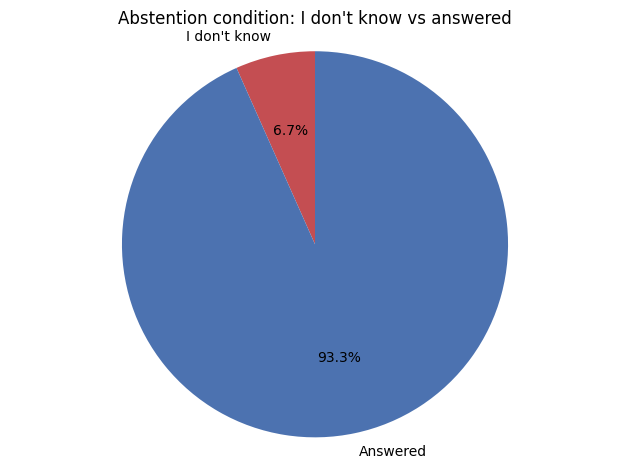

In [35]:
# Filter to abstention condition
abst_df = results_df[results_df["condition"] == "abstention"]

idk_counts = abst_df["said_idk"].value_counts()
idk_true = idk_counts.get(True, 0)
idk_false = idk_counts.get(False, 0)

values = [idk_true, idk_false]
labels = ["I don't know", "Answered"]
colours = ["#C44E52", "#4C72B0"]  

plt.figure()
plt.pie(
    values,
    labels=labels,
    colors=colours,
    autopct="%1.1f%%",
    startangle=90,
)
plt.title("Abstention condition: I don't know vs answered")
plt.axis("equal")
plt.tight_layout()
plt.show()
